## Mediapipe Baseline Comparison

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os

# Define landmark indices
left_eye_upper_indices = [33, 157, 133]
left_eye_lower_indices = [7, 144, 154]
right_eye_upper_indices = [263, 385, 362]
right_eye_lower_indices = [249, 373, 381]
left_eyebrow_indices = [55, 65, 52, 63, 70]
right_eyebrow_indices = [285, 295, 282, 293, 300]

# Mediapipe initialization
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

def calculate_midpoint(lm1, lm2):
    midpoint_x = (lm1.x + lm2.x) / 2
    midpoint_y = (lm1.y + lm2.y) / 2
    return midpoint_x, midpoint_y

def extract_landmark_coords(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        coords = []
        
        # Add the coordinates for the left eyebrow
        for idx_list in [left_eyebrow_indices]:
            for idx in idx_list:
                lm = face_landmarks.landmark[idx]
                coords.append((lm.x, lm.y))
        
        # Calculate midpoints for the left eye
        left_eye_midpoints = [
            calculate_midpoint(face_landmarks.landmark[left_eye_upper_indices[0]], face_landmarks.landmark[left_eye_lower_indices[0]]),
            calculate_midpoint(face_landmarks.landmark[left_eye_upper_indices[1]], face_landmarks.landmark[left_eye_lower_indices[1]]),
            calculate_midpoint(face_landmarks.landmark[left_eye_upper_indices[2]], face_landmarks.landmark[left_eye_lower_indices[2]])
        ]
        
        # Append left midpoints to the coordinates
        coords.extend(left_eye_midpoints)
        
        # Add the coordinates for the right eyebrow
        for idx_list in [right_eyebrow_indices]:
            for idx in idx_list:
                lm = face_landmarks.landmark[idx]
                coords.append((lm.x, lm.y))
        
        # Calculate midpoints for the right eye
        right_eye_midpoints = [
            calculate_midpoint(face_landmarks.landmark[right_eye_upper_indices[0]], face_landmarks.landmark[right_eye_lower_indices[0]]),
            calculate_midpoint(face_landmarks.landmark[right_eye_upper_indices[1]], face_landmarks.landmark[right_eye_lower_indices[1]]),
            calculate_midpoint(face_landmarks.landmark[right_eye_upper_indices[2]], face_landmarks.landmark[right_eye_lower_indices[2]])
        ]
        
        # Append right midpoints to the coordinates
        coords.extend(right_eye_midpoints)
        
        return coords
    return None

In [2]:
def calculate_features(coords_list):
    coords_array = np.array(coords_list)
    features = []
    
    # Calculate averages and standard deviations separately for x and y coordinates
    x_avgs = []
    y_avgs = []
    x_sds = []
    y_sds = []
    
    # Iterate over each of the 8 points
    for i in range(8):
        x_coords = [coord[0] for coord in coords_array[i]]  # X coordinates for the i-th point
        y_coords = [coord[1] for coord in coords_array[i]]  # Y coordinates for the i-th point
        
        # Calculate average and standard deviation for x and y coordinates
        x_avg = np.mean(x_coords)
        y_avg = np.mean(y_coords)
        x_sd = np.std(x_coords)
        y_sd = np.std(y_coords)
        
        # Append calculated features to the respective lists
        x_avgs.append(x_avg)
        y_avgs.append(y_avg)
        x_sds.append(x_sd)
        y_sds.append(y_sd)
    
    # Extend features in the correct order
    features.extend(x_avgs[:5])  # 5 x averages for the eyebrow
    features.extend(x_sds[:5])   # 5 x standard deviations for the eyebrow
    features.extend(y_avgs[:5])  # 5 y averages for the eyebrow
    features.extend(y_sds[:5])   # 5 y standard deviations for the eyebrow
    features.extend(x_avgs[5:])  # 3 x averages for the eye
    features.extend(x_sds[5:])   # 3 x standard deviations for the eye
    features.extend(y_avgs[5:])  # 3 y averages for the eye
    features.extend(y_sds[5:])   # 3 y standard deviations for the eye

    return features

def process_subfolder(subfolder_path):
    frame_files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]
    all_coords_left = [[] for _ in range(8)]
    all_coords_right = [[] for _ in range(8)]
    
    for frame_file in frame_files:
        coords = extract_landmark_coords(frame_file)
        if coords:
            left_eye_coords = coords[:8]  # First 8 points for left side (5 eyebrow + 3 midpoints)
            right_eye_coords = coords[8:]  # Last 8 points for right side (5 eyebrow + 3 midpoints)
            for i in range(8):
                all_coords_left[i].append(left_eye_coords[i])  # Append (x, y) coordinate
                all_coords_right[i].append(right_eye_coords[i])  # Append (x, y) coordinate
    
    
    if not all_coords_left or not all_coords_right:
        return None
    
    all_coords_left = np.array(all_coords_left)
    all_coords_right = np.array(all_coords_right)
    
    left_eye_features = calculate_features(all_coords_left)
    right_eye_features = calculate_features(all_coords_right)
    
    return left_eye_features + right_eye_features

def save_features_to_csv(main_dir, output_csv):
    subfolders = [os.path.join(main_dir, f) for f in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, f))]
    rows = []
    
    for subfolder in subfolders:
        features = process_subfolder(subfolder)
        if features:
            subfolder_name = os.path.basename(subfolder)
            rows.append([subfolder_name] + features + [0])
    
    column_names = ['subfolder_name'] + \
                    [f'left_eyebrow_x{i}_avg' for i in range(1, 6)] + [f'left_eyebrow_x{i}_sd' for i in range(1, 6)] + \
                    [f'left_eyebrow_y{i}_avg' for i in range(1, 6)] + [f'left_eyebrow_y{i}_sd' for i in range(1, 6)] + \
                    [f'left_eye_x{i}_avg' for i in range(1, 4)] + [f'left_eye_x{i}_sd' for i in range(1, 4)] + \
                    [f'left_eye_y{i}_avg' for i in range(1, 4)] + [f'left_eye_y{i}_sd' for i in range(1, 4)] + \
                    [f'right_eyebrow_x{i}_avg' for i in range(1, 6)] + [f'right_eyebrow_x{i}_sd' for i in range(1, 6)] + \
                    [f'right_eyebrow_y{i}_avg' for i in range(1, 6)] + [f'right_eyebrow_y{i}_sd' for i in range(1, 6)] + \
                    [f'right_eye_x{i}_avg' for i in range(1, 4)] + [f'right_eye_x{i}_sd' for i in range(1, 4)] + \
                    [f'right_eye_y{i}_avg' for i in range(1, 4)] + [f'right_eye_y{i}_sd' for i in range(1, 4)] + \
                    ['label']
    
    df = pd.DataFrame(rows, columns=column_names)
    df.to_csv(output_csv, index=False)

# Paths
main_dir = 'D:\\harsh\\Blepharospasm\\Normal Frames with Time'
output_csv = 'D:\harsh\Blepharospasm\\normal_features.csv'

# Save features to CSV
save_features_to_csv(main_dir, output_csv)


c:\Users\harsh\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

In [15]:
data = pd.read_csv(r"D:\\harsh\\Blepharospasm\\Experiment\\Baseline Comparators\\Mediapipe\\mediapipe features.csv")

In [16]:
data.head(5)

subfolder_name  left_eyebrow_x1_avg  left_eyebrow_x1_sd  \
0             101             0.497051            0.012056   
1             102             0.477622            0.025497   
2             103             0.458183            0.015533   
3             104             0.401162            0.026942   
4             105             0.435256            0.009832   

   left_eyebrow_x2_avg  left_eyebrow_x2_sd  left_eyebrow_x3_avg  \
0             0.475155            0.012714             0.457990   
1             0.450768            0.024884             0.430224   
2             0.435623            0.014627             0.420966   
3             0.350732            0.027998             0.313922   
4             0.363470            0.010606             0.309581   

   left_eyebrow_x3_sd  left_eyebrow_x4_avg  left_eyebrow_x4_sd  \
0            0.012998             0.440951            0.012962   
1            0.024389             0.409695            0.023942   
2            0.013429             0.409498            0.012039   
3            0.028792             0.278504            0.029825   
4            0.010987             0.252934            0.010969   

   left_eyebrow_x5_avg  ...  right_eye_x2_sd  right_eye_x3_avg  \
0             0.430752  ...         0.009838          0.543125   
1             0.398546  ...         0.024215          0.538551   
2             0.407177  ...         0.014804          0.524827   
3             0.261551  ...         0.025221          0.529873   
4             0.223750  ...         0.011733          0.599567   

   right_eye_x3_sd  right_eye_y1_avg  right_eye_y1_sd  right_eye_y2_avg  \
0         0.010422          0.427605         0.014380          0.416116   
1         0.023842          0.575459         0.027944          0.574281   
2         0.013908          0.395769         0.023037          0.395725   
3         0.024791          0.357601         0.067782          0.359919   
4         0.011769          0.286077         0.043978          0.268057   

   right_eye_y2_sd  right_eye_y3_avg  right_eye_y3_sd  label  
0         0.014967          0.407969         0.014934      1  
1         0.029050          0.572948         0.029695      1  
2         0.024500          0.400274         0.021901      1  
3         0.068262          0.361522         0.064956      1  
4         0.044169          0.270086         0.047945      1  

[5 rows x 66 columns]

In [17]:
#drop subfolder_name and save to new df
final_data = data.drop("subfolder_name", axis = 1)

In [18]:
final_data.head(5)

left_eyebrow_x1_avg  left_eyebrow_x1_sd  left_eyebrow_x2_avg  \
0             0.497051            0.012056             0.475155   
1             0.477622            0.025497             0.450768   
2             0.458183            0.015533             0.435623   
3             0.401162            0.026942             0.350732   
4             0.435256            0.009832             0.363470   

   left_eyebrow_x2_sd  left_eyebrow_x3_avg  left_eyebrow_x3_sd  \
0            0.012714             0.457990            0.012998   
1            0.024884             0.430224            0.024389   
2            0.014627             0.420966            0.013429   
3            0.027998             0.313922            0.028792   
4            0.010606             0.309581            0.010987   

   left_eyebrow_x4_avg  left_eyebrow_x4_sd  left_eyebrow_x5_avg  \
0             0.440951            0.012962             0.430752   
1             0.409695            0.023942             0.398546   
2             0.409498            0.012039             0.407177   
3             0.278504            0.029825             0.261551   
4             0.252934            0.010969             0.223750   

   left_eyebrow_x5_sd  ...  right_eye_x2_sd  right_eye_x3_avg  \
0            0.012680  ...         0.009838          0.543125   
1            0.023707  ...         0.024215          0.538551   
2            0.010255  ...         0.014804          0.524827   
3            0.030585  ...         0.025221          0.529873   
4            0.010176  ...         0.011733          0.599567   

   right_eye_x3_sd  right_eye_y1_avg  right_eye_y1_sd  right_eye_y2_avg  \
0         0.010422          0.427605         0.014380          0.416116   
1         0.023842          0.575459         0.027944          0.574281   
2         0.013908          0.395769         0.023037          0.395725   
3         0.024791          0.357601         0.067782          0.359919   
4         0.011769          0.286077         0.043978          0.268057   

   right_eye_y2_sd  right_eye_y3_avg  right_eye_y3_sd  label  
0         0.014967          0.407969         0.014934      1  
1         0.029050          0.572948         0.029695      1  
2         0.024500          0.400274         0.021901      1  
3         0.068262          0.361522         0.064956      1  
4         0.044169          0.270086         0.047945      1  

[5 rows x 65 columns]

In [7]:
# Assuming 'target' is the column you want to predict
X = final_data.drop('label', axis=1)  # Features
y = final_data['label']  # Target variable

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)


In [10]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)


In [11]:

# Standardize the data
scaler = StandardScaler()

# Define models to test
models = {
    'RandomForest': RandomForestClassifier(max_depth=10, n_estimators=100),
    'SVM': SVC(gamma=0.1, kernel='rbf'),
    'LogisticRegression': LogisticRegression(C=10, solver='liblinear'),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=30),
    'MLP': MLPClassifier(activation='relu', hidden_layer_sizes=(100,), solver='sgd', max_iter=2000),
    'XGBoost': XGBClassifier(learning_rate=0.1,n_estimators=100)
}

# Create a pipeline for each model and use regularized cross-validation to evaluate the model

pipelines = {name: Pipeline([ ('model', model)]) for name, model in models.items()}


In [19]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model

# Assuming X and y are your features and target
X = final_data.drop(columns=['label'])  # Replace with your actual target column name
y = final_data['label']

# Initialize cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Initialize a confusion matrix accumulator and accuracy list
n_classes = len(np.unique(y))
confusion_matrix_sum = np.zeros((n_classes, n_classes), dtype=int)
accuracies = []

# Example pipeline (replace 'RandomForest' with the actual model you want to use)
pipeline = Pipeline([
    ('model', RandomForestClassifier(max_depth=None, n_estimators=300))
])

# Perform cross-validation
for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Compute the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    
    # Accumulate the confusion matrix
    confusion_matrix_sum += cm
    
    # Compute the accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Average the confusion matrix and raound to integer values
average_confusion_matrix = np.round(confusion_matrix_sum / rkf.get_n_splits()).astype(int)

# Average accuracy across all folds
average_accuracy = np.mean(accuracies)

# Output the results
print("Average Confusion Matrix (rounded to integer values):")
print(average_confusion_matrix)

print(f"Average Accuracy: {average_accuracy:.2f}")


Average Confusion Matrix (rounded to integer values):
[[12  3]
 [ 4 10]]
Average Accuracy: 0.77


In [35]:
results = {}
for model_name, model in pipelines.items():
    model_scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring='accuracy')
    results[model_name] = {
        'mean_score': np.mean(model_scores),
        'std_score': np.std(model_scores)
    }

for model_name, scores in results.items():
    print(f"{model_name} - Mean Score: {scores['mean_score']:.4f}")

RandomForest - Mean Score: 0.7122
SVM - Mean Score: 0.3508
LogisticRegression - Mean Score: 0.7278
KNN - Mean Score: 0.4044
DecisionTree - Mean Score: 0.6521
MLP - Mean Score: 0.4765
XGBoost - Mean Score: 0.7219


In [12]:
# Example parameter grids (customize these based on your requirements)
param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'SVM': {
        'model__C': [0.1, 1, 10,100,150],
        'model__gamma': [1, 0.1, 0.01],
        'model__kernel': ['rbf', 'linear']
    },
    'LogisticRegression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'DecisionTree': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 1]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu', 'tanh'],
        'model__solver': ['adam', 'sgd']
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 1]
    }
}

In [13]:
# Perform GridSearchCV for each model
best_estimators = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=rkf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f'{name} best parameters: {grid_search.best_params_}')
    print(f'{name} best score: {grid_search.best_score_}')

RandomForest best parameters: {'model__max_depth': None, 'model__n_estimators': 300}
RandomForest best score: 0.721991341991342
SVM best parameters: {'model__C': 150, 'model__gamma': 1, 'model__kernel': 'rbf'}
SVM best score: 0.8175757575757575
LogisticRegression best parameters: {'model__C': 10, 'model__solver': 'liblinear'}
LogisticRegression best score: 0.7238528138528139
KNN best parameters: {'model__n_neighbors': 3, 'model__weights': 'distance'}
KNN best score: 0.769134199134199
DecisionTree best parameters: {'model__max_depth': 30, 'model__min_samples_split': 10}
DecisionTree best score: 0.6415151515151514
MLP best parameters: {'model__activation': 'tanh', 'model__hidden_layer_sizes': (100,), 'model__solver': 'adam'}
MLP best score: 0.8009523809523807
XGBoost best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
XGBoost best score: 0.7136363636363636


Evaluation for RandomForest:
Accuracy: 0.8888888888888888
Precision: 0.8950617283950617
Recall: 0.8888888888888888
F1 Score: 0.889232886136911


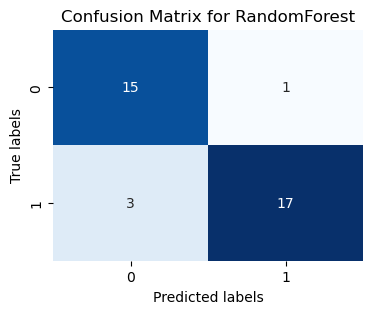

Evaluation for SVM:
Accuracy: 0.8888888888888888
Precision: 0.8950617283950617
Recall: 0.8888888888888888
F1 Score: 0.889232886136911


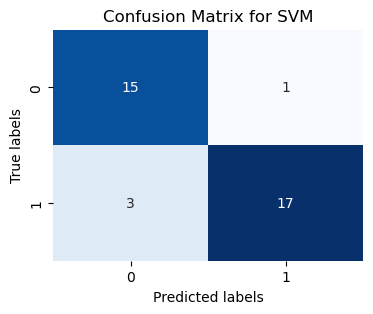

Evaluation for LogisticRegression:
Accuracy: 0.9166666666666666
Precision: 0.9298245614035088
Recall: 0.9166666666666666
F1 Score: 0.9168597168597168


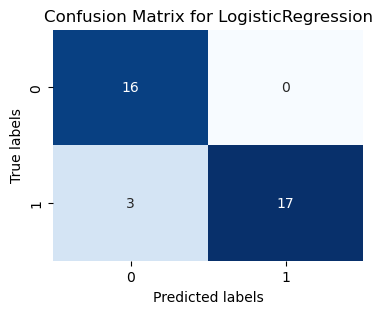

Evaluation for KNN:
Accuracy: 0.8333333333333334
Precision: 0.8787878787878788
Recall: 0.8333333333333334
F1 Score: 0.8317853457172342


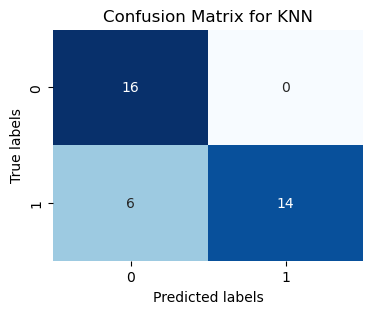

Evaluation for DecisionTree:
Accuracy: 0.6944444444444444
Precision: 0.7717171717171717
Recall: 0.6944444444444444
F1 Score: 0.6836261911006206


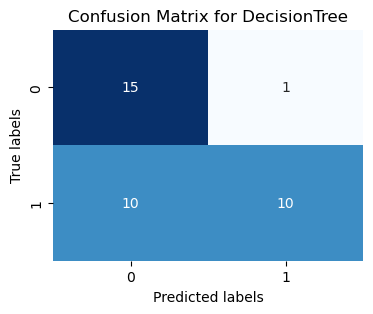

Evaluation for MLP:
Accuracy: 0.9722222222222222
Precision: 0.9738562091503269
Recall: 0.9722222222222222
F1 Score: 0.9722869722869724


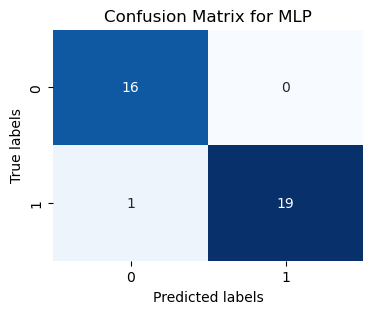

Evaluation for XGBoost:
Accuracy: 0.8333333333333334
Precision: 0.8541666666666666
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334


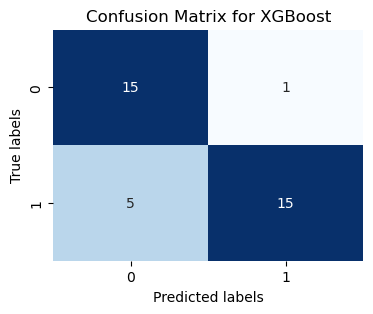

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate model
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Evaluation for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Plot confusion matrix
    cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Evaluate each best model
for name, model in best_estimators.items():
    evaluate_model(name, model, X_test, y_test)


## Naive Resnet50 

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd

# Define the modified ResNet model to get embeddings from the avgpool layery
class ResNetEmbedding(nn.Module):
    def __init__(self):
        super(ResNetEmbedding, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Keep all layers except the fc layer

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor to (batch_size, 2048)
        return x


# Load the pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetEmbedding().to(device).eval()

# Preprocessing function to match ResNet-50 input requirements
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension
    return image

# Function to get embeddings
def get_embedding(image_path):
    image = load_and_preprocess_image(image_path)
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().numpy().flatten()

# Function to process a subfolder and get embeddings
def process_subfolder(subfolder_path):
    left_eye_folder = os.path.join(subfolder_path, "Left Eye")
    right_eye_folder = os.path.join(subfolder_path, "Right Eye")

    left_eye_files = [os.path.join(left_eye_folder, f) for f in os.listdir(left_eye_folder) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]
    right_eye_files = [os.path.join(right_eye_folder, f) for f in os.listdir(right_eye_folder) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]

    left_eye_samples = random.sample(left_eye_files, min(30, len(left_eye_files)))
    right_eye_samples = random.sample(right_eye_files, min(30, len(right_eye_files)))

    all_embeddings = []

    for image_path in left_eye_samples + right_eye_samples:
        embedding = get_embedding(image_path)
        all_embeddings.append(embedding)

    all_embeddings = np.array(all_embeddings)
    avg_embeddings = np.mean(all_embeddings, axis=0)
    sd_embeddings = np.std(all_embeddings, axis=0)

    return avg_embeddings, sd_embeddings

# Function to save features to CSV
def save_features_to_csv(main_dir, output_csv):
    subfolders = [os.path.join(main_dir, f) for f in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, f))]
    rows = []

    for subfolder in subfolders:
        avg_embeddings, sd_embeddings = process_subfolder(subfolder)
        subfolder_name = os.path.basename(subfolder)
        features = np.concatenate([avg_embeddings, sd_embeddings])
        row = [subfolder_name] + features.tolist() + [0]
        rows.append(row)

    column_names = ['subfolder_name'] + [f'avg_embedding_{i}' for i in range(len(avg_embeddings))] + [f'sd_embedding_{i}' for i in range(len(sd_embeddings))] + ['label']
    df = pd.DataFrame(rows, columns=column_names)
    df.to_csv(output_csv, index=False)

# Paths
main_dir = 'D:\\harsh\\Blepharospasm\\Extracted Colored Eye\\Normal Eyes With Eyebrows'
output_csv = 'D:\\harsh\\Blepharospasm\\Baseline Comparators\\Naive ResNet\\embeddings_normal_features.csv'

# Save features to CSV
save_features_to_csv(main_dir, output_csv)


c:\Users\harsh\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harsh\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
data = pd.read_csv(r"D:\\harsh\\Blepharospasm\\Experiment\\Baseline Comparators\\ResNet Embeddings\\resnet_features.csv")

In [28]:
data.head(5)

subfolder_name  avg_embedding_0  avg_embedding_1  avg_embedding_2  \
0             101         0.271900         0.182501         0.652543   
1             102         0.461864         0.177526         0.447391   
2             103         0.456824         0.325595         0.375204   
3             104         0.269592         0.153160         0.251108   
4             105         0.254823         0.236620         0.156405   

   avg_embedding_3  avg_embedding_4  avg_embedding_5  avg_embedding_6  \
0         0.086354         0.425617         0.496088         0.735516   
1         0.021027         0.499571         0.398576         0.504337   
2         0.089812         0.157801         0.190463         0.716893   
3         0.042931         0.403813         0.350038         0.310070   
4         0.062243         0.688631         0.215016         0.397058   

   avg_embedding_7  avg_embedding_8  ...  sd_embedding_2039  \
0         0.017191         1.090181  ...           0.032534   
1         0.031168         1.334911  ...           0.063843   
2         0.005381         0.941952  ...           0.033309   
3         0.076377         0.960448  ...           0.125146   
4         0.132418         0.825650  ...           0.129498   

   sd_embedding_2040  sd_embedding_2041  sd_embedding_2042  sd_embedding_2043  \
0           0.058443           0.116558           0.067038           0.027749   
1           0.101292           0.071289           0.096373           0.006270   
2           0.086536           0.166652           0.146394           0.008442   
3           0.047544           0.271694           0.127952           0.023421   
4           0.040159           0.104921           0.081260           0.016561   

   sd_embedding_2044  sd_embedding_2045  sd_embedding_2046  sd_embedding_2047  \
0           0.098376           0.072495           0.125101           0.312408   
1           0.080955           0.091171           0.088430           0.295696   
2           0.125492           0.202865           0.050523           0.281793   
3           0.111901           0.126654           0.105564           0.410875   
4           0.162160           0.203470           0.086161           0.297107   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

[5 rows x 4098 columns]

In [29]:
#drop subfolder_name and save to new df
final_data = data.drop("subfolder_name", axis = 1)

In [30]:
final_data.head(5)

avg_embedding_0  avg_embedding_1  avg_embedding_2  avg_embedding_3  \
0         0.271900         0.182501         0.652543         0.086354   
1         0.461864         0.177526         0.447391         0.021027   
2         0.456824         0.325595         0.375204         0.089812   
3         0.269592         0.153160         0.251108         0.042931   
4         0.254823         0.236620         0.156405         0.062243   

   avg_embedding_4  avg_embedding_5  avg_embedding_6  avg_embedding_7  \
0         0.425617         0.496088         0.735516         0.017191   
1         0.499571         0.398576         0.504337         0.031168   
2         0.157801         0.190463         0.716893         0.005381   
3         0.403813         0.350038         0.310070         0.076377   
4         0.688631         0.215016         0.397058         0.132418   

   avg_embedding_8  avg_embedding_9  ...  sd_embedding_2039  \
0         1.090181         0.242520  ...           0.032534   
1         1.334911         0.177364  ...           0.063843   
2         0.941952         0.110888  ...           0.033309   
3         0.960448         0.283320  ...           0.125146   
4         0.825650         0.191404  ...           0.129498   

   sd_embedding_2040  sd_embedding_2041  sd_embedding_2042  sd_embedding_2043  \
0           0.058443           0.116558           0.067038           0.027749   
1           0.101292           0.071289           0.096373           0.006270   
2           0.086536           0.166652           0.146394           0.008442   
3           0.047544           0.271694           0.127952           0.023421   
4           0.040159           0.104921           0.081260           0.016561   

   sd_embedding_2044  sd_embedding_2045  sd_embedding_2046  sd_embedding_2047  \
0           0.098376           0.072495           0.125101           0.312408   
1           0.080955           0.091171           0.088430           0.295696   
2           0.125492           0.202865           0.050523           0.281793   
3           0.111901           0.126654           0.105564           0.410875   
4           0.162160           0.203470           0.086161           0.297107   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

[5 rows x 4097 columns]

In [31]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model

# Assuming X and y are your features and target
X = final_data.drop(columns=['label'])  # Replace with your actual target column name
y = final_data['label']

# Initialize cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Initialize a confusion matrix accumulator and accuracy list
n_classes = len(np.unique(y))
confusion_matrix_sum = np.zeros((n_classes, n_classes), dtype=int)
accuracies = []

# Example pipeline (replace 'RandomForest' with the actual model you want to use)
pipeline = Pipeline([
    ('model', RandomForestClassifier(max_depth=30, n_estimators=100))
])

# Perform cross-validation
for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Compute the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    
    # Accumulate the confusion matrix
    confusion_matrix_sum += cm
    
    # Compute the accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Average the confusion matrix and raound to integer values
average_confusion_matrix = np.round(confusion_matrix_sum / rkf.get_n_splits()).astype(int)

# Average accuracy across all folds
average_accuracy = np.mean(accuracies)

# Output the results
print("Average Confusion Matrix (rounded to integer values):")
print(average_confusion_matrix)

print(f"Average Accuracy: {average_accuracy:.2f}")


Average Confusion Matrix (rounded to integer values):
[[13  2]
 [ 2 12]]
Average Accuracy: 0.86


In [42]:
# Assuming 'target' is the column you want to predict
X = data.drop('label', axis=1)  # Features
y = data['label']  # Target variable

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [44]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)


In [45]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)


In [46]:

# Standardize the data
scaler = StandardScaler()

# Define models to test
models = {
    'RandomForest': RandomForestClassifier(max_depth=10, n_estimators=100),
    'SVM': SVC(gamma=0.1, kernel='rbf'),
    'LogisticRegression': LogisticRegression(C=10, solver='liblinear'),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=30),
    'MLP': MLPClassifier(activation='relu', hidden_layer_sizes=(100,), solver='sgd', max_iter=2000),
    'XGBoost': XGBClassifier(learning_rate=0.1,n_estimators=100)
}

# Create a pipeline for each model and use regularized cross-validation to evaluate the model

pipelines = {name: Pipeline([ ('model', model)]) for name, model in models.items()}


In [47]:
results = {}
for model_name, model in pipelines.items():
    model_scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring='accuracy')
    results[model_name] = {
        'mean_score': np.mean(model_scores),
        'std_score': np.std(model_scores)
    }

for model_name, scores in results.items():
    print(f"{model_name} - Mean Score: {scores['mean_score']:.4f}")

RandomForest - Mean Score: 0.8326
SVM - Mean Score: 0.5182
LogisticRegression - Mean Score: 0.8559
KNN - Mean Score: 0.7685
DecisionTree - Mean Score: 0.7378
MLP - Mean Score: 0.5229
XGBoost - Mean Score: 0.8236


In [48]:
# Example parameter grids (customize these based on your requirements)
param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'SVM': {
        'model__C': [0.1, 1, 10,100,150],
        'model__gamma': [1, 0.1, 0.01],
        'model__kernel': ['rbf', 'linear']
    },
    'LogisticRegression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'DecisionTree': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 1]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu', 'tanh'],
        'model__solver': ['adam', 'sgd']
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 1]
    }
}

In [49]:
# Perform GridSearchCV for each model
best_estimators = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=rkf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f'{name} best parameters: {grid_search.best_params_}')
    print(f'{name} best score: {grid_search.best_score_}')

RandomForest best parameters: {'model__max_depth': 30, 'model__n_estimators': 100}
RandomForest best score: 0.8484848484848484
SVM best parameters: {'model__C': 1, 'model__gamma': 1, 'model__kernel': 'linear'}
SVM best score: 0.8512121212121211
LogisticRegression best parameters: {'model__C': 1, 'model__solver': 'liblinear'}
LogisticRegression best score: 0.8594805194805194
KNN best parameters: {'model__n_neighbors': 7, 'model__weights': 'uniform'}
KNN best score: 0.7941991341991341
DecisionTree best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5}
DecisionTree best score: 0.7556709956709956
MLP best parameters: {'model__activation': 'tanh', 'model__hidden_layer_sizes': (50,), 'model__solver': 'adam'}
MLP best score: 0.8586147186147187
XGBoost best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
XGBoost best score: 0.8235930735930737


Evaluation for RandomForest:
Accuracy: 0.8611111111111112
Precision: 0.8630890952872377
Recall: 0.8611111111111112
F1 Score: 0.8614348614348616


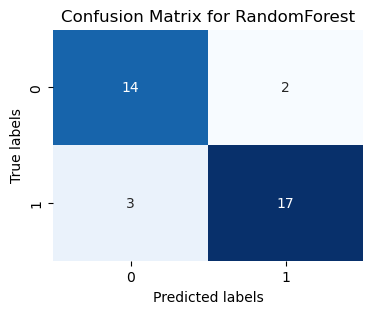

Evaluation for SVM:
Accuracy: 0.8888888888888888
Precision: 0.8950617283950617
Recall: 0.8888888888888888
F1 Score: 0.889232886136911


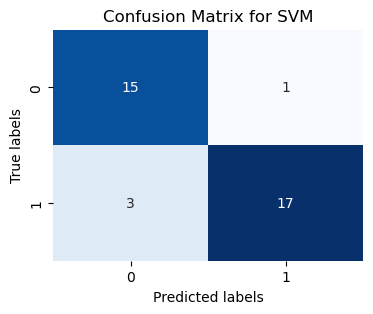

Evaluation for LogisticRegression:
Accuracy: 0.8888888888888888
Precision: 0.8950617283950617
Recall: 0.8888888888888888
F1 Score: 0.889232886136911


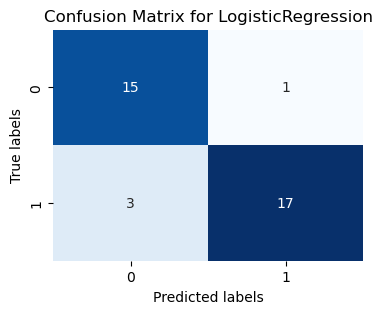

Evaluation for KNN:
Accuracy: 0.7222222222222222
Precision: 0.7402777777777777
Recall: 0.7222222222222222
F1 Score: 0.7222222222222223


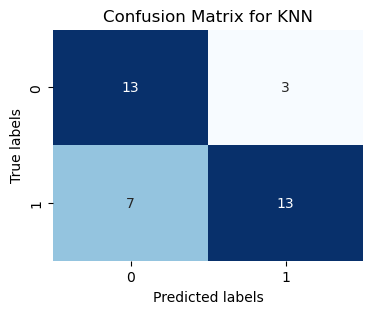

Evaluation for DecisionTree:
Accuracy: 0.75
Precision: 0.7492063492063491
Recall: 0.75
F1 Score: 0.7490165224232886


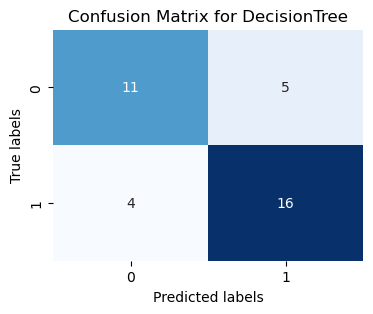

Evaluation for MLP:
Accuracy: 0.8333333333333334
Precision: 0.8395061728395061
Recall: 0.8333333333333334
F1 Score: 0.8338493292053665


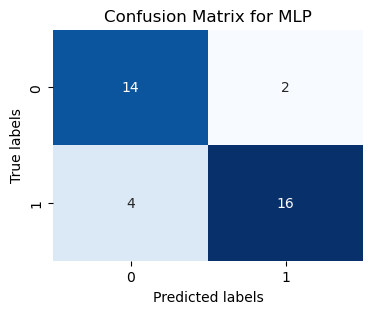

Evaluation for XGBoost:
Accuracy: 0.75
Precision: 0.761609907120743
Recall: 0.75
F1 Score: 0.7505791505791506


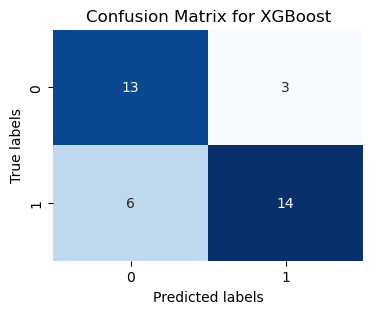

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate model
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Evaluation for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Plot confusion matrix
    cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Evaluate each best model
for name, model in best_estimators.items():
    evaluate_model(name, model, X_test, y_test)


## Open/Close prediction without including tight blinks

In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define paths

tight_blink_path = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Tight Closed'
normal_blink_path = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Normal Closed'

# Load ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(50, 50, 3))

# Function to extract features using ResNet50
def extract_features(image_path, model):
    img = load_img(image_path, target_size=(50, 50))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img)
    return features.flatten()

# Load and process images
def load_dataset(image_paths, model):
    features = []
    labels = []
    for img_path in image_paths:
        # Debugging: Print the image path
        print(f"Processing image: {img_path}")
        
        # Check if the file exists
        if not os.path.exists(img_path):
            print(f"File does not exist: {img_path}")
            continue
        
        try:
            features.append(extract_features(img_path, model))
            if 'Tight Closed' in img_path:
                labels.append(1)  # Label for tight blink
            else:
                labels.append(0)  # Label for normal blink
        except PermissionError as e:
            print(f"PermissionError: {e}")
            continue
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
    return np.array(features), np.array(labels)

# Get all image paths
tight_blink_images = [os.path.join(tight_blink_path, img_name) for img_name in os.listdir(tight_blink_path)]
normal_blink_images = [os.path.join(normal_blink_path, img_name) for img_name in os.listdir(normal_blink_path)]
image_paths = tight_blink_images + normal_blink_images

# Extract features and labels
X, y = load_dataset(image_paths, base_model)


Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) Detection Dataset\Tight\10.jpg
1/1 [==============================] - 2s 2s/step
Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) Detection Dataset\Tight\10001.jpg
1/1 [==============================] - 0s 114ms/step
Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) Detection Dataset\Tight\10002.jpg
1/1 [==============================] - 0s 155ms/step
Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) Detection Dataset\Tight\10003.jpg
1/1 [==============================] - 0s 88ms/step
Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) Detection Dataset\Tight\10005.jpg
1/1 [==============================] - 0s 109ms/step
Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) Detection Dataset\Tight\10006.jpg
1/1 [==============================] - 0s 100ms/step
Processing image: D:\harsh\Blepharospasm\Dataset\Blink (incl. tight) De

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")


Accuracy on test set: 0.99


In [14]:
# Function to predict tight blink on a new image
def predict_tight_blink(image_path, model, classifier):
    features = extract_features(image_path, model)
    prediction = classifier.predict([features])
    return 'Tight Blink' if prediction[0] == 1 else 'Normal Blink'

# Example prediction on a new image
new_image_path = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Normal Closed\\0.jpg'
result = predict_tight_blink(new_image_path, base_model, svm_clf)
print(f"Prediction: {result}")


1/1 [==============================] - 1s 1s/step
Prediction: Normal Blink


### classify blinks into normal and tight and save them in seperate folder

In [16]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define paths
source_dir = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Closed'
tight_blink_dir = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Tight'
normal_blink_dir = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Normal'

# Create directories if they don't exist
os.makedirs(tight_blink_dir, exist_ok=True)
os.makedirs(normal_blink_dir, exist_ok=True)

# Function to predict and save images
def predict_and_save_images(source_dir, tight_blink_dir, normal_blink_dir, model, classifier):
    # Get list of all image paths in the source directory
    image_paths = [os.path.join(source_dir, img_name) for img_name in os.listdir(source_dir)]
    
    # Process all images in the directory
    for img_path in image_paths:
        # Predict whether the image is a tight blink or normal blink
        prediction = predict_tight_blink(img_path, model, classifier)
        
        # Determine the target directory based on the prediction
        if prediction == 'Tight Blink':
            target_dir = tight_blink_dir
        else:
            target_dir = normal_blink_dir
        
        # Save the image to the corresponding directory
        shutil.copy(img_path, target_dir)

# Function to predict tight blink using the pre-trained ResNet model and SVM classifier
def predict_tight_blink(image_path, model, classifier):
    features = extract_features(image_path, model)
    prediction = classifier.predict([features])
    return 'Tight Blink' if prediction[0] == 1 else 'Normal Blink'

# Use the defined function to predict and save images
predict_and_save_images(source_dir, tight_blink_dir, normal_blink_dir, base_model, svm_clf)


1/1 [==============================] - 0s 113ms/step


In [1]:
# define predicted class 0 for Closed and 1 for Open
classes = ['Closed', 'Open']

In [2]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [3]:
import os
import csv
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
# Load the saved model
model = tf.keras.models.load_model('C:\\Users\\harsh\\Downloads\\resnet50_without_tight_blink (1).h5')

In [4]:
import re
# Define the path to the directory containing the images
directory = 'D:\\harsh\\Blepharospasm\\Dataset\\Blink (incl. tight) Detection Dataset\\Tight'

# Helper function to extract timestamp from filename
def extract_timestamp(filename):
    match = re.search(r'frame_(\d+)ms\.jpg', filename)
    if match:
        return int(match.group(1))
    return -1

# List all files in the directory and sort them by extracted timestamp
image_files = sorted(
    [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))],
    key=extract_timestamp
)

predictions = []
timestamps = []

# Preprocess and predict the class for each image
for img_file in image_files:
    # Extract timestamp from filename and store it
    timestamp = extract_timestamp(img_file)
    timestamps.append(timestamp)

    # Load the image using the Keras image module
    img_path = os.path.join(directory, img_file)
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand the dimensions of the image
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the model
    prediction = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(prediction[0])
    predictions.append(predicted_class)
    
    # Print the predicted class for the current image
    print(f"Image: {img_file}, Timestamp: {timestamp}ms, Predicted class: {classes[predicted_class]}")


1/1 [==============================] - 3s 3s/step
Image: 10.jpg, Timestamp: -1ms, Predicted class: Open
1/1 [==============================] - 0s 299ms/step
Image: 10001.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 311ms/step
Image: 10002.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 285ms/step
Image: 10003.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 276ms/step
Image: 10005.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 272ms/step
Image: 10006.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 289ms/step
Image: 10011.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 303ms/step
Image: 10012.jpg, Timestamp: -1ms, Predicted class: Closed
1/1 [==============================] - 0s 283ms/step
Image: 10013.jpg, Timestamp: -1ms, Predicted class: Closed


In [5]:
print(predictions)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 

In [6]:
# count nu count of open/close eyes in the predictions
open_count = predictions.count(1)
close_count = predictions.count(0)

print(f"Open Eye Count: {open_count}")
print(f"Closed Eye Count: {close_count}")



Open Eye Count: 1200
Closed Eye Count: 11473


In [7]:
accuracy = close_count / len(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 90.53%
